## Part 1

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.integrate as integrate
from scipy.interpolate import griddata
import sympy as sp
from sympy import Symbol, Function, Eq, Derivative, dsolve, solve, simplify

In [32]:
import os
fig_dir = 'figs'
table_dir = 'tables'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
if not os.path.exists(table_dir):
    os.makedirs(table_dir)

In [33]:
mi_Xe = 131.293*1.66*10**-27
elem_charge = 1.6*10**-19
r0=1 # meters

In [34]:
# Angle phi is given in radians
def beam2(phi, a0=0.0014895, a1=103.12, a2=60.169):
    return a0 + a1 / (a2 + (phi*180/np.pi)**2)

def beam3(phi, b1=1.9, b2=5, b3=0.12):
    try:
        epsilon = 1e-2  # Small value to avoid division by zero
        phi_adjusted = np.where(phi <= 1e-3, epsilon, phi)
        exponent = -b2 * phi**2 / (b3 + phi_adjusted**1.6)
        # Cap the exponent to prevent overflow in the exp function
        exponent = np.clip(exponent, -20, 20)
        vals = b1 * np.exp(exponent)
        return np.real(vals)  # Return the real part in case of complex numbers
    except Exception as e:
        return np.zeros_like(phi)  # Return an array of zeros of the same shape

def beam4(phi, I0=0.195, beta=50.231, r0=1):
    return (I0*(beta+1)) / (2*np.pi*r0**2) * np.cos(phi)**beta

def beam1(r, phi, beamf=beam2, r0=1):
    return beamf(phi) * (r/r0)**-2

def delta(phi):
    return (beam2(phi)-beam3(phi)) / beam2(phi)

def energy_dist(phi, b0=-185.59, b1=2.898*10**6, b2=6839.0, toJ=False):
    if toJ:
        return (b0 + b1 / (b2 + (phi*180/np.pi)**2)) * 1.602*10**-19
    else:
        return b0 + b1 / (b2 + (phi*180/np.pi)**2) # energy in eV

def vel_dist(phi, mi=mi_Xe, ed=energy_dist):
    return np.sqrt(2*ed(phi)*1.602*10**-19 / mi) # velocity in m/s

In [35]:
n_points = 100
phi_range = np.linspace(0, np.pi/2, n_points)
r_range = np.linspace(0, 2, n_points)


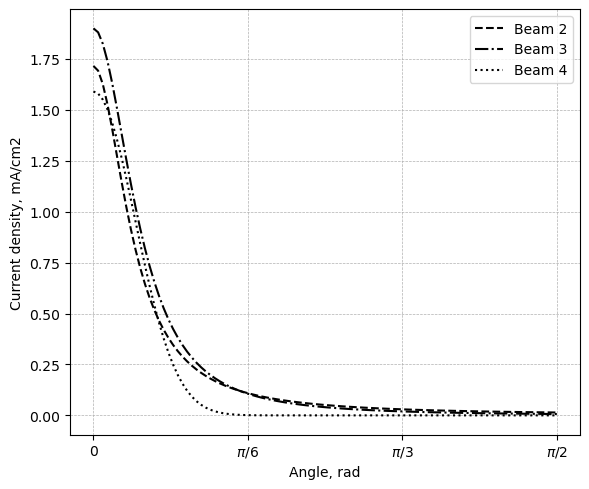

In [6]:
plt.figure(figsize=(6,5))
plt.plot(phi_range, beam2(phi_range), label='Beam 2', color='k', linestyle='--')
plt.plot(phi_range, beam3(phi_range), label='Beam 3', color='k', linestyle='-.')
plt.plot(phi_range, beam4(phi_range), label='Beam 4', color='k', linestyle=':')
plt.xlabel('Angle, rad')
plt.ylabel(r'Current density, mA/cm2')
plt.legend()
plt.xticks([0, np.pi/6, np.pi/3, np.pi/2], ['0', r'$\pi/6$', r'$\pi/3$', r'$\pi/2$'])
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'beams_models_2-3-4.png'), dpi=300)
plt.show()

I0 = 0.202 mA/cm2
beta = 47.226
r0 = 1 m


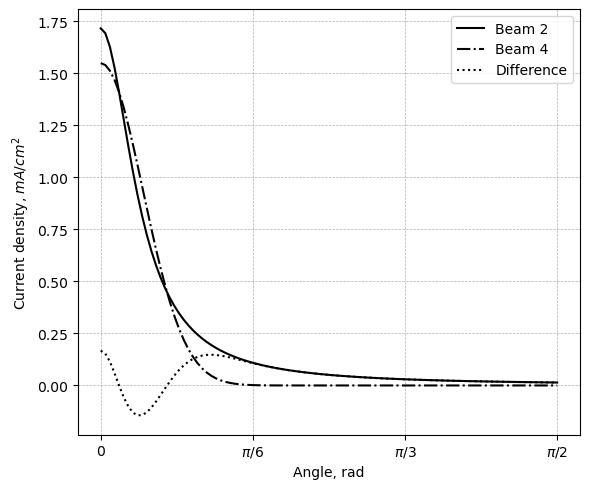

In [7]:
# Fit beam4 to beam2 varying I0, beta, r0
from scipy.optimize import curve_fit
popt, pcov = curve_fit(beam4, phi_range, beam2(phi_range), p0=[0.2, 50])
print(
    f'I0 = {popt[0]:.3f} mA/cm2\n'
    f'beta = {popt[1]:.3f}\n'
    f'r0 = 1 m'
)
plt.figure(figsize=(6,5))
plt.plot(phi_range, beam2(phi_range), label='Beam 2', color='k', linestyle='-')
plt.plot(phi_range, beam4(phi_range, *popt), label='Beam 4', color='k', linestyle='-.')
dif_vals = lambda phi: beam2(phi) - beam4(phi, *popt)
plt.plot(phi_range, dif_vals(phi_range), label='Difference', color='k', linestyle=':')
plt.xlabel('Angle, rad')
plt.ylabel(r'Current density, $mA/cm^2$')
plt.legend()
plt.xticks([0, np.pi/6, np.pi/3, np.pi/2], ['0', r'$\pi/6$', r'$\pi/3$', r'$\pi/2$'])
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'beams_model_fit_4to2.png'), dpi=300)
plt.show()

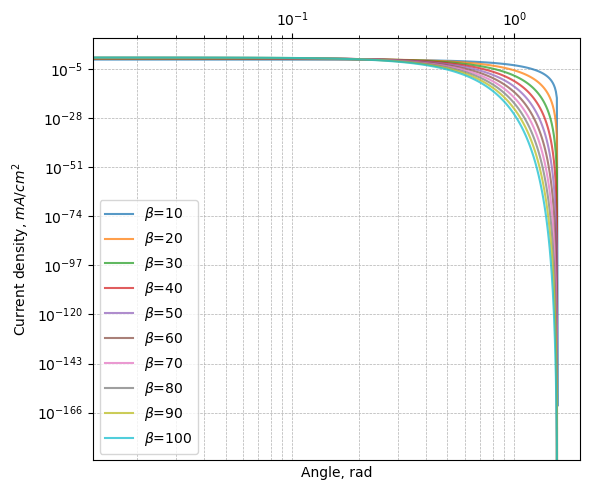

In [8]:
colors = plt.cm.tab10(np.linspace(0, 1, 10))
plt.figure(figsize=(6,5))
for c, b in zip(colors, np.linspace(10, 100, 10)):
    plt.plot(phi_range, beam4(phi_range, beta=b), label=r'$\beta$='+f"{b:.0f}", color=c,\
             linewidth=1.5, alpha=0.75)
plt.xlabel('Angle, rad')
plt.ylabel(r'Current density, $mA/cm^2$')
plt.legend()
plt.yscale('log')
plt.xticks([0, np.pi/6, np.pi/3, np.pi/2], ['0', r'$\pi/6$', r'$\pi/3$', r'$\pi/2$'])
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.gca().xaxis.tick_top()
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'beam_model_4_beta.png'), dpi=300)
plt.show()

## Part 2

### 2.1

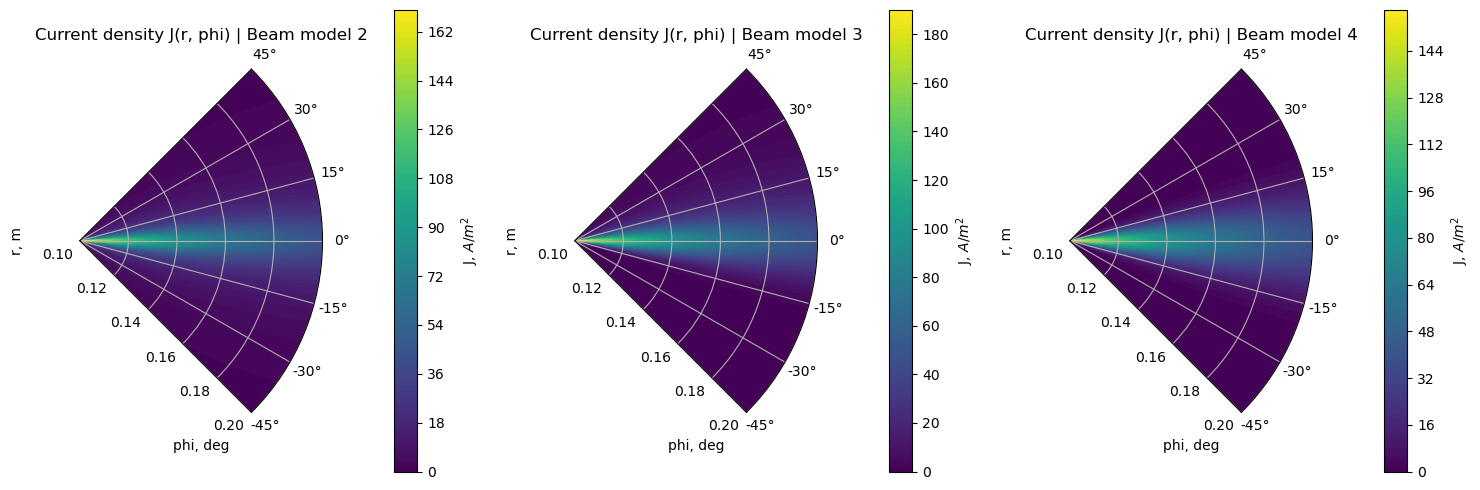

In [9]:
fig, axes = plt.subplots(1, 3, subplot_kw=dict(polar=True), figsize=(15, 5))

n_points = 100
lvls = n_points
rmax = 0.2
# rmin = 0
thetamin = -45
thetamax = 45
phi_range = np.linspace(-np.pi/2, np.pi/2, n_points)
r_range = np.linspace(0.1, 2, n_points)

phi_range = np.linspace(-np.pi/2, np.pi/2, n_points)
for i, beam_model in enumerate([beam2, beam3, beam4]):
    R, PHI = np.meshgrid(r_range, phi_range)
    J = beam1(R, PHI, beamf=beam_model)

    ax = axes[i]
    contour = ax.contourf(PHI, R, J, 100)
    ax.set_title(f'Current density J(r, phi) | Beam model {i+2}')
    ax.set_xlabel('phi, deg')
    ax.set_ylabel('r, m')
    ax.set_rmax(rmax)
    ax.set_thetamin(thetamin)
    ax.set_thetamax(thetamax)
    # Add a colorbar to the current subplot
    fig.colorbar(contour, ax=ax, orientation='vertical', label=r'J, $A/m^2$')

plt.tight_layout()
# plt.savefig(os.path.join(fig_dir, 'current_density_J_polar_dist.png'), dpi=300)
plt.show()

### 2.2

In [10]:
phi_s, I0_s, a0_s, a1_s, a2_s, r0 = sp.symbols('varphi I_0 a_0 a_1 a_2 r_0')
j0_s = sp.Function('j_0')(phi_s, a0_s, a1_s, a2_s)
j0_s = a0_s + a1_s / (a2_s + phi_s)
j0_s

a_0 + a_1/(a_2 + varphi)

In [11]:
io_s = sp.integrate(j0_s*sp.sin(phi_s), (phi_s, 0, sp.pi/2)) * sp.pi * 2 * r0
io_s

2*pi*r_0*Integral((a_0*a_2 + a_0*varphi + a_1)*sin(varphi)/(a_2 + varphi), (varphi, 0, pi/2))

In [12]:
def I0(phi, r, low_b, up_b, r0=1, beamf=beam2):
    int_func = lambda phi: beamf(phi) * np.sin(phi)
    return 2 * np.pi * r0**2 * integrate.quad(int_func, low_b, up_b)[0] * 10 # in A

def G0(phi, r, low_b, up_b, io_=I0, e=elem_charge, mi=mi_Xe):
    return I0(phi, r, low_b, up_b) / e * mi

def P0(phi, low_b, up_b, r0=1, e=elem_charge, mi=mi_Xe, beamf=beam2, velf=vel_dist):
    mean_vel = np.trapz(velf(phi), phi) / (phi[-1]-phi[0])
    int_func = lambda phi: beamf(phi)/e * np.cos(phi) * np.sin(phi)
    return 2 * np.pi * r0**2 * mi * mean_vel*integrate.quad(int_func, low_b, up_b)[0] * 10

In [13]:
io = I0(phi_range, r_range, 0, np.pi/2)
g0 = G0(phi_range, r_range, 0, np.pi/2)
p0 = P0(phi_range, 0, np.pi/2)
print(f"Integral current {io:.3f} A")
print(f"Mass flux {g0:.3e} kg/s")
print(f"Axial integral impulse {p0:.4f} N")

Integral current 4.572 A
Mass flux 6.227e-06 kg/s
Axial integral impulse 0.0673 N


In [14]:
alpha_range = np.linspace(0, np.pi/2, n_points)
io_alpha_range = np.array([I0(phi_range, r_range, a, np.pi/2) for a in alpha_range])
p0_alpha_range = np.array([P0(phi_range, a, np.pi/2) for a in alpha_range])
g0_alpha_range = np.array([G0(phi_range, r_range, a, np.pi/2) for a in alpha_range])

# io_alpha_range = np.cumsum(np.array([I0(phi_range, r_range, a, np.pi/2) for a in alpha_range]))
# p0_alpha_range = np.cumsum(np.array([P0(phi_range, a, np.pi/2) for a in alpha_range]))
# g0_alpha_range = np.cumsum(np.array([G0(phi_range, r_range, a, np.pi/2) for a in alpha_range]))

io_alpha_range.shape, p0_alpha_range.shape, g0_alpha_range.shape
pr_th = 95
io_95 = np.percentile(io_alpha_range, pr_th)
p0_95 = np.percentile(p0_alpha_range, pr_th)
g0_95 = np.percentile(g0_alpha_range, pr_th)
io_a95 = alpha_range[np.where(io_alpha_range >= io_95)[0]]
p0_a95 = alpha_range[np.where(p0_alpha_range >= p0_95)[0]]
g0_a95 = alpha_range[np.where(g0_alpha_range >= g0_95)[0]]
print(f"95th percentile integral current {io_95:.3f} A")
print(f"95th percentile mass flux {g0_95:.3e} kg/s")
print(f"95th percentile axial integral impulse {p0_95:.4f} N")

print(f"angle for i0 95: {io_a95*180/np.pi}")
print(f"angle for p0 95: {p0_a95*180/np.pi}")
print(f"angle for g0 95: {g0_a95*180/np.pi}")


95th percentile integral current 4.285 A
95th percentile mass flux 5.837e-06 kg/s
95th percentile axial integral impulse 0.0621 N
angle for i0 95: [0.         0.90909091 1.81818182 2.72727273 3.63636364]
angle for p0 95: [0.         0.90909091 1.81818182 2.72727273 3.63636364]
angle for g0 95: [0.         0.90909091 1.81818182 2.72727273 3.63636364]


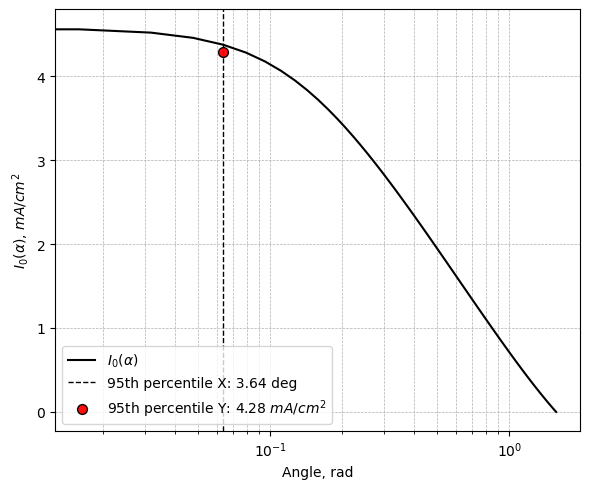

In [15]:
plt.figure(figsize=(6,5))
plt.plot(alpha_range, io_alpha_range, color='k', label=r"$I_0(\alpha)$")
plt.xlabel('Angle, rad')
plt.ylabel(r'$I_0(\alpha)$, $mA/cm^2$')
plt.xticks([0, np.pi/6, np.pi/3, np.pi/2], ['0', r'$\pi/6$', r'$\pi/3$', r'$\pi/2$'])
plt.axvline(io_a95[-1], color='k', linestyle='--', linewidth=1, label=f'95th percentile X: {io_a95[-1]*180/np.pi:.2f} deg')
plt.scatter(io_a95[-1], io_95, c='r', s=50, alpha=0.95, label=f'95th percentile Y: {io_95:.2f} '+r'$mA/cm^2$', edgecolor='k', zorder=10)
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0,2))
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.xscale('log')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'current_density_I_alpha_dist.png'), dpi=300)
plt.show()

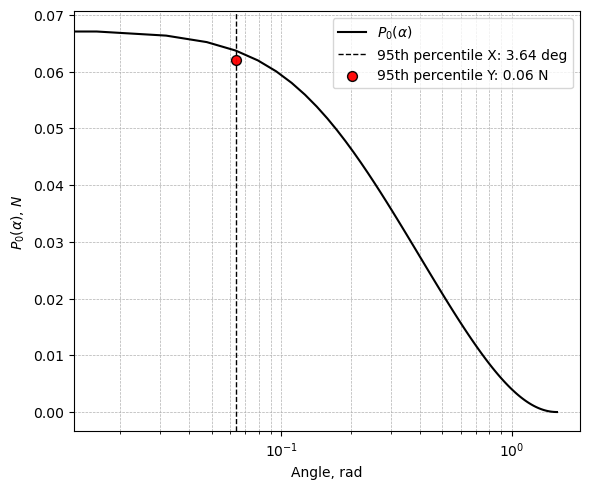

In [16]:
plt.figure(figsize=(6,5))
plt.plot(alpha_range, p0_alpha_range, color='k', label=r"$P_0(\alpha)$")
plt.xlabel('Angle, rad')
plt.ylabel(r'$P_0(\alpha)$, $N$')
plt.xticks([0, np.pi/6, np.pi/3, np.pi/2], ['0', r'$\pi/6$', r'$\pi/3$', r'$\pi/2$'])
plt.axvline(p0_a95[-1], color='k', linestyle='--', linewidth=1, label=f'95th percentile X: {p0_a95[-1]*180/np.pi:.2f} deg')
plt.scatter(p0_a95[-1], p0_95, c='r', s=50, alpha=0.95, label=f'95th percentile Y: {p0_95:.2f} N', edgecolor='k', zorder=10)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.xscale('log')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'current_density_P_alpha_dist.png'), dpi=300)
plt.show()

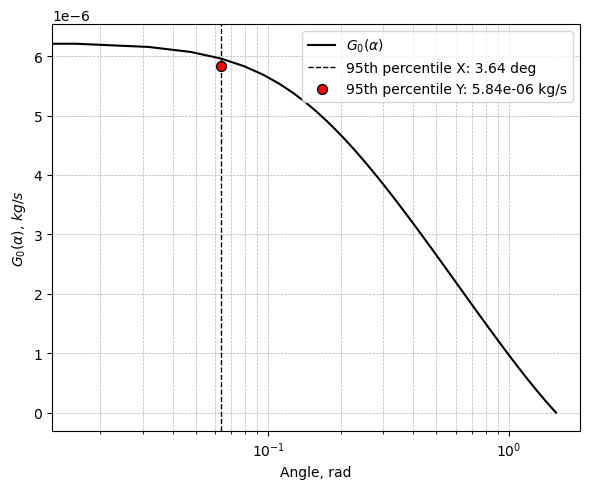

In [17]:
plt.figure(figsize=(6,5))
plt.plot(alpha_range, g0_alpha_range, color='k', label=r"$G_0(\alpha)$")
plt.xlabel('Angle, rad')
plt.ylabel(r'$G_0(\alpha)$, $kg/s$')
plt.xticks([0, np.pi/6, np.pi/3, np.pi/2], ['0', r'$\pi/6$', r'$\pi/3$', r'$\pi/2$'])
plt.axvline(g0_a95[-1], color='k', linestyle='--', linewidth=1, label=f'95th percentile X: {g0_a95[-1]*180/np.pi:.2f} deg')
plt.scatter(g0_a95[-1], g0_95, c='r', s=50, alpha=1, label=f'95th percentile Y: {g0_95:.2e} kg/s', zorder=10, edgecolor='k')
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0,2))
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.xscale('log')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'current_density_G_alpha_dist.png'), dpi=300)
plt.show()

### Part 3

In [18]:
def qi(r, phi, theta, beamf=beam2, energyd=energy_dist):
    return beam1(r, phi, beamf, r0=1) * energyd(phi, toJ=False) * np.cos(theta) * 10 # from mA/cm2 to A/m2
def qs(Qs, As):
    return Qs * As

def teq(r, phi, theta, Qs, As, epsilon, sigma=5.670 * 1e-8, beamf=beam2, energyd=energy_dist):
        return (
             (qs(Qs, As) + qi(r, phi, theta, beamf, energyd)) / epsilon * sigma
        )**0.25

In [19]:
Qs = 1360.8 # W/m2
sigma_b = 5.670 * 1e-8 # W/(m^2*K^4)
As_lst = np.array([0.8, 0.85, 0.6, 0.55, 0.15, 0.25, 0.05, 0.3])
epsilon_lst = np.array([0.15, 0.9, 0.45, 0.9, 0.05, 0.25, 0.85, 0.9])
theta_lsp = np.linspace(0, np.pi/2, n_points)

In [20]:
print(f"{125**4:.2e}")

2.44e+08


In [21]:
print(f"{1 / (sigma_b * epsilon_lst[1]):.2e}")

1.96e+07


In [22]:
print(f"{qs(Qs, As_lst[1]) + qi(1, np.pi/4, np.pi/4):.2e}")

1.21e+03


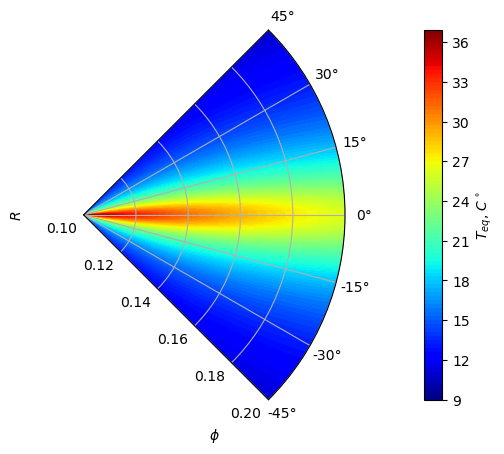

In [23]:
R, PHI = np.meshgrid(r_range, phi_range)
Teq = teq(R, PHI, np.pi/4, Qs, As_lst[1], epsilon_lst[1], sigma=sigma_b) * 1e2

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
contour = ax.contourf(PHI, R, Teq, levels=lvls, cmap='jet')
fig.colorbar(contour, orientation='vertical', label=r'$T_{eq}$, $C^\circ$')
ax.set_xlabel(r'$\phi$')
ax.set_ylabel(r'$R$')
ax.set_rmax(rmax)
ax.set_thetamin(thetamin)
ax.set_thetamax(thetamax)
plt.show()

In [24]:
Teq.shape, R.shape, PHI.shape

((100, 100), (100, 100), (100, 100))

## Part 4

In [25]:
a_sp = 5   # m
b_sp = 2.5 # m
z_sp = 2.5 # m
hd = 2.5   # m
zd = 1     # m

alpha_d = 0 / 180 * np.pi # in radians
origin = np.array([hd, 0, zd])
sh_vec = np.array([np.cos(alpha_d), 0, np.sin(alpha_d)])

sp_z = np.linspace(0, a_sp, n_points) + z_sp
sp_y = np.linspace(-b_sp/2, b_sp/2, n_points)
spZ, spY = np.meshgrid(sp_z, sp_y)

In [27]:
def calcAngle(vec1, vec2, deg=False):
    '''
    Calculate the angle between two vectors
    x1 : float - x component of first vector
    y1 : float - y component of first vector
    z1 : float - z component of first vector

    x2 : float - x component of second vector
    y2 : float - y component of second vector
    z2 : float - z component of second vector
    '''
    dot_prod = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if deg:
        return np.arccos(dot_prod / (norm1 * norm2)) * 180/np.pi
    else:
        return np.arccos(dot_prod / (norm1 * norm2))
                

In [28]:
theta_ar = np.zeros_like(spZ)
phi_ar = np.zeros_like(spZ)
for i in range(n_points):
    for j in range(n_points):
        point = np.array([0, spY[i, j], spZ[i, j]])
        radius_vector = origin - point
        normal_vector = np.array([1, 0, 0])
        theta_ar[i,j] = calcAngle(radius_vector, normal_vector, deg=True)
        phi_ar[i,j] = calcAngle(radius_vector, sh_vec, deg=True)

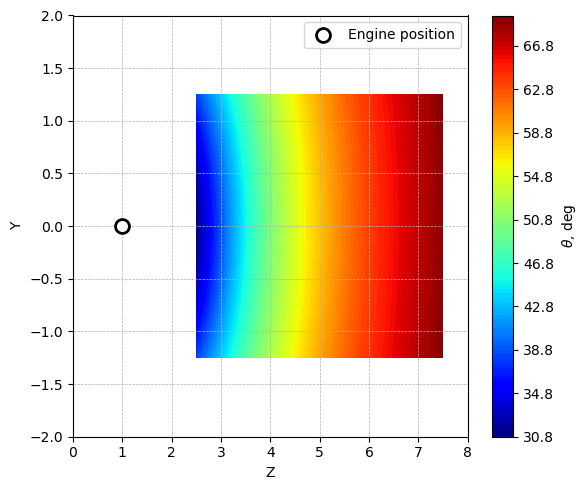

In [29]:
# Plot the contour
plt.figure(figsize=(6, 5))
plt.scatter(origin[2], origin[1], c='white',\
            s=100, zorder=10, alpha=1, label='Engine position', edgecolors='black', linewidths=2)
plt.contourf(spZ, spY, theta_ar, levels=lvls, cmap='jet')
plt.xlim(0, 8)
plt.ylim(-2, 2)
plt.xlabel("Z")
plt.ylabel("Y")
plt.colorbar(label=r"$\theta$, deg")
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
# plt.savefig(os.path.join(fig_dir, 'current_angle_thete_dist.png'), dpi=300)
plt.show()

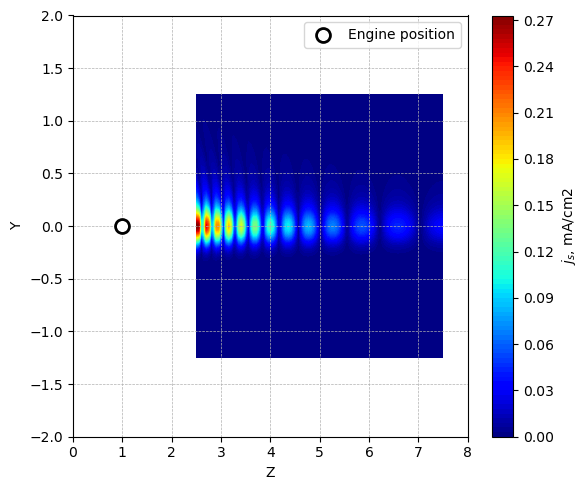

In [30]:
J = beam1(spZ, spY, beamf=beam3, r0=1)
# Plot the contour
plt.figure(figsize=(6, 5))
plt.scatter(origin[2], origin[1], c='white',\
            s=100, zorder=10, alpha=1, label='Engine position', edgecolors='black', linewidths=2)
plt.contourf(spZ, spY, abs(J*np.cos(theta_ar)), levels=lvls, cmap='jet')
plt.xlim(0, 8)
plt.ylim(-2, 2)
plt.xlabel("Z")
plt.ylabel("Y")
plt.colorbar(label=r"$j_s$, mA/cm2")
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'current_J_thete_dist.png'), dpi=300)
plt.show()